In [1]:
# Full example for my blog post at:
# https://danijar.com/building-variational-auto-encoders-in-tensorflow/

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import sys
import os
tfd = tf.contrib.distributions

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Epoch 0 elbo -530.2986
Epoch 1 elbo 566.5554
Epoch 2 elbo 1352.5332
Epoch 3 elbo 1222.4902
Epoch 4 elbo 1526.9346
Epoch 5 elbo 1597.6278
Epoch 6 elbo 1521.3954
Epoch 7 elbo 1348.9625
Epoch 8 elbo 1450.0043
Epoch 9 elbo 1458.0974
Epoch 10 elbo 1615.04
Epoch 11 elbo 1879.92
Epoch 12 elbo 1887.691
Epoch 13 elbo 1741.8632
Epoch 14 elbo 1984.9152
Epoch 15 elbo 1842.322
Epoch 16 elbo 1802.762
Epoch 17 elbo 1965.5262
Epoch 18 elbo 2044.7084
Epoch 19 elbo 2143.2693


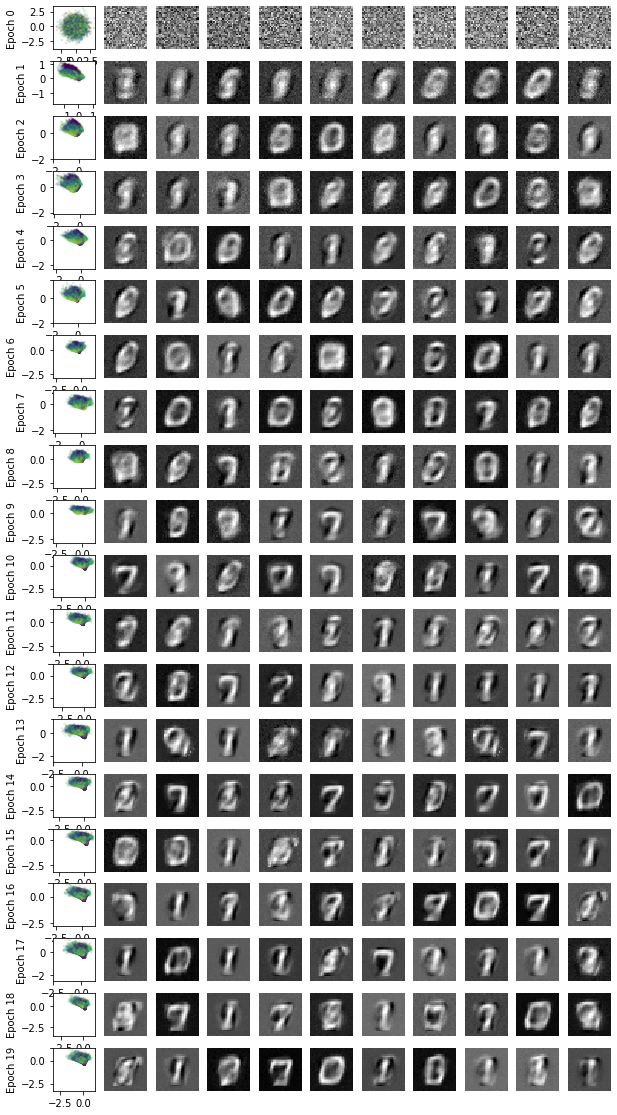

In [49]:
def make_encoder(data, code_size):
    x = tf.layers.flatten(data)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, code_size)
    scale = tf.layers.dense(x, code_size, tf.nn.softplus)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_prior(code_size):
    loc = tf.zeros(code_size)
    scale = tf.ones(code_size)
    return tfd.MultivariateNormalDiag(loc, scale)


def make_decoder(code, n_dim):
    x = code
    x = tf.layers.dense(x, 256, tf.nn.relu)
    x = tf.layers.dense(x, 256, tf.nn.relu)
    loc = tf.layers.dense(x, 28 * 28)
    scale = tf.layers.dense(x, 28 * 28, tf.nn.softplus)
    #scale = tf.ones(28*28)
    loc = tf.reshape(loc, [-1] + [28, 28])
    scale = tf.reshape(scale, [-1] + [28, 28])
    return tfd.Independent(tfd.MultivariateNormalDiag(loc, scale))
    #return tfd.MultivariateNormalDiag(loc, scale)

def plot_codes(ax, codes, labels):
    ax.scatter(codes[:, 0], codes[:, 1], s=2, c=labels, alpha=0.1)
    ax.set_aspect('equal')
    ax.set_xlim(codes.min() - .1, codes.max() + .1)
    ax.set_ylim(codes.min() - .1, codes.max() + .1)
    ax.tick_params(
        axis='both', which='both', left='off', bottom='off',
        labelleft='off', labelbottom='off')


def plot_samples(ax, samples):
    for index, sample in enumerate(samples):
        ax[index].imshow(sample, cmap='gray')
        ax[index].axis('off')

def latent_fig(epoch):
    nx = ny = 20
    x_values = np.linspace(-3, 3, nx)
    y_values = np.linspace(-3, 3, ny)
    print("After Epoch ", epoch, " :")
    canvas = np.empty((28*ny, 28*nx))
    for i, yi in enumerate(x_values):
      for j, xi in enumerate(y_values):
        z_mu = np.array([[xi, yi]]*128)
        x_mean = sess.run(latent_samples, feed_dict={noise: z_mu})
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = x_mean[0]
    
    plt.figure(figsize=(8, 10))        
    Xi, Yi = np.meshgrid(x_values, y_values)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.tight_layout()


data = tf.placeholder(tf.float32, [None, 28, 28])
code_size=8
make_encoder = tf.make_template('encoder', make_encoder)
make_decoder = tf.make_template('decoder', make_decoder)

# Define the model.
prior = make_prior(code_size=code_size)
posterior = make_encoder(data, code_size=code_size)
code = posterior.sample()

# Define the loss.
likelihood = make_decoder(code, [28, 28]).log_prob(data)
divergence = tfd.kl_divergence(posterior, prior)
elbo = tf.reduce_mean(likelihood - 0.1 * divergence)
optimize = tf.train.AdamOptimizer(0.001).minimize(-elbo)
init_op = tf.initialize_all_variables()

samples = make_decoder(prior.sample(10), [28, 28]).mean()

noise = tf.placeholder(tf.float32, shape=[None, code_size])
latent_samples = make_decoder(noise, [28, 28]).mean() 

mnist = input_data.read_data_sets('MNIST_data/')
fig, ax = plt.subplots(nrows=20, ncols=11, figsize=(10, 20))

with tf.train.MonitoredSession() as sess:
    sess.run(init_op)
    for epoch in range(20):
        feed = {data: mnist.test.images.reshape([-1, 28, 28])}
        test_elbo, test_codes, test_samples = sess.run([elbo, code, samples], feed)
        print('Epoch', epoch, 'elbo', test_elbo)
        ax[epoch, 0].set_ylabel('Epoch {}'.format(epoch))
        plot_codes(ax[epoch, 0], test_codes, mnist.test.labels)
        plot_samples(ax[epoch, 1:], test_samples)
        #latent_fig(epoch)
        for _ in range(600):
            feed = {data: mnist.train.next_batch(128)[0].reshape([-1, 28, 28])}
            sess.run(optimize, feed)
plt.savefig('vae-mnist.png', dpi=300, transparent=True, bbox_inches='tight')